# 0 - import

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import networkx as nx
import itertools
import community


from community import community_louvain as louvain
from networkx.algorithms import bipartite
from networkx.algorithms.link_prediction import jaccard_coefficient
from networkx.algorithms.community.quality import modularity
from sklearn.model_selection import train_test_split
from collections import defaultdict

In [52]:
pd.read_csv('beer_reviews.csv')

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1586609,14359,The Defiant Brewing Company,1162684892,5.0,4.0,3.5,maddogruss,Pumpkin Ale,4.0,4.0,The Horseman's Ale,5.2,33061
1586610,14359,The Defiant Brewing Company,1161048566,4.0,5.0,2.5,yelterdow,Pumpkin Ale,2.0,4.0,The Horseman's Ale,5.2,33061
1586611,14359,The Defiant Brewing Company,1160702513,4.5,3.5,3.0,TongoRad,Pumpkin Ale,3.5,4.0,The Horseman's Ale,5.2,33061
1586612,14359,The Defiant Brewing Company,1160023044,4.0,4.5,4.5,dherling,Pumpkin Ale,4.5,4.5,The Horseman's Ale,5.2,33061


In [53]:
beer_df = pd.read_csv("beer_reviews.csv")
list(beer_df.columns)

['brewery_id',
 'brewery_name',
 'review_time',
 'review_overall',
 'review_aroma',
 'review_appearance',
 'review_profilename',
 'beer_style',
 'review_palate',
 'review_taste',
 'beer_name',
 'beer_abv',
 'beer_beerid']

In [54]:
beer_df = beer_df.rename(columns={'beer_beerid': 'beer_id'})

In [55]:
beer_df.head(4)

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_id
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969


In [56]:
beer_df.shape

(1586614, 13)

In [57]:
beer_df.dtypes

brewery_id              int64
brewery_name           object
review_time             int64
review_overall        float64
review_aroma          float64
review_appearance     float64
review_profilename     object
beer_style             object
review_palate         float64
review_taste          float64
beer_name              object
beer_abv              float64
beer_id                 int64
dtype: object

# 1 - Preprocessing, Data Cleaning & Dataset Inspection

#### 1.1 - Column "review_time".

In [58]:
beer_df['review_time'] = pd.to_datetime(beer_df['review_time'], unit="s")
beer_df['review_time'].iloc[-3:]

1586611   2006-10-13 01:21:53
1586612   2006-10-05 04:37:24
1586613   2006-10-04 23:41:59
Name: review_time, dtype: datetime64[ns]

When is the first beer review occurred, and the last one?

In [59]:
str(beer_df['review_time'].dt.date.min()) + ' to ' + str(beer_df['review_time'].dt.date.max())

'1996-08-22 to 2012-01-11'

Check how many observations are there for each year. This can help me deciding whether to subset the data frame.

In [60]:
beer_df.groupby(beer_df['review_time'].dt.year).size()

review_time
1996         1
1998       133
1999        86
2000       119
2001      1999
2002     23140
2003     56958
2004     69701
2005     89116
2006    129648
2007    142404
2008    210099
2009    243402
2010    277072
2011    333072
2012      9664
dtype: int64

#### 1.2 - Check for unique, null, duplicates and infinite values

In [61]:
beer_df.nunique()

brewery_id               5840
brewery_name             5742
review_time           1577960
review_overall             10
review_aroma                9
review_appearance          10
review_profilename      33387
beer_style                104
review_palate               9
review_taste                9
beer_name               56857
beer_abv                  530
beer_id                 66055
dtype: int64

There seems to be a discrepancy between brewery_id and brewery_name, but couldn't come up with a way of solving this discrepancy. How is it possible that there are more `brewery_id` than `brewery_name`?

Remove the `na`.

In [62]:
beer_df.isnull().sum()

brewery_id                0
brewery_name             15
review_time               0
review_overall            0
review_aroma              0
review_appearance         0
review_profilename      348
beer_style                0
review_palate             0
review_taste              0
beer_name                 0
beer_abv              67785
beer_id                   0
dtype: int64

In [63]:
beer_df = beer_df.dropna()

In [64]:
beer_df.query(
    '   review_profilename=="gtermi" and beer_name=="Robert The Bruce Scottish Ale"'
)


,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_id
1330089,26,Three Floyds Brewing Co. & Brewpub,2012-01-05 05:10:58,4.0,3.5,4.0,gtermi,Scottish Ale,4.0,3.5,Robert The Bruce Scottish Ale,6.5,1159


Check for duplicates.

In [65]:
beer_df.duplicated().sum()

0

#### 1.3 - Inspect the distributions

In [66]:
beer_df.describe().round(2)

,brewery_id,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,beer_id
count,1518478.00,1518478.00,1518478.00,1518478.00,1518478.00,1518478.00,1518478.00,1518478.00
mean,3074.31,3.82,3.75,3.85,3.75,3.80,7.04,21405.75
std,5544.34,0.72,0.70,0.61,0.68,0.73,2.32,21780.33
min,1.00,0.00,1.00,0.00,1.00,1.00,0.01,5.00
25%,141.00,3.50,3.50,3.50,3.50,3.50,5.20,1654.00
50%,417.00,4.00,4.00,4.00,4.00,4.00,6.50,12830.00
75%,2298.00,4.50,4.00,4.00,4.00,4.50,8.50,39236.00
max,28003.00,5.00,5.00,5.00,5.00,5.00,57.70,77316.00


Start from the reviews.

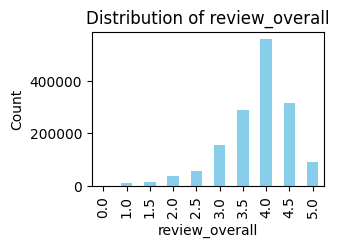

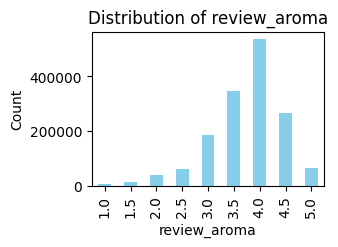

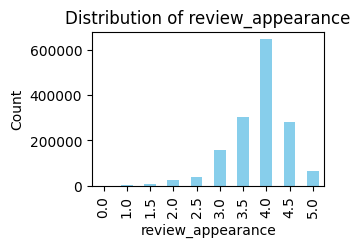

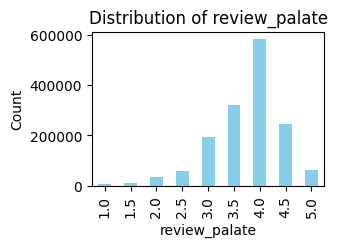

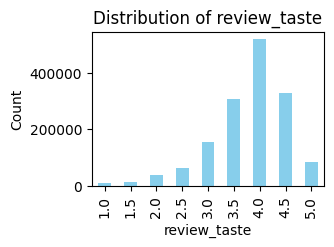

In [67]:
rating_columns = ['review_overall', 'review_aroma', 'review_appearance', 'review_palate', 'review_taste']

for column in rating_columns:
    plt.figure(figsize=(3, 2))
    beer_df[column].value_counts().sort_index().plot(kind='bar', color='skyblue')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()

Double check for uncoherent/inconsistent values.

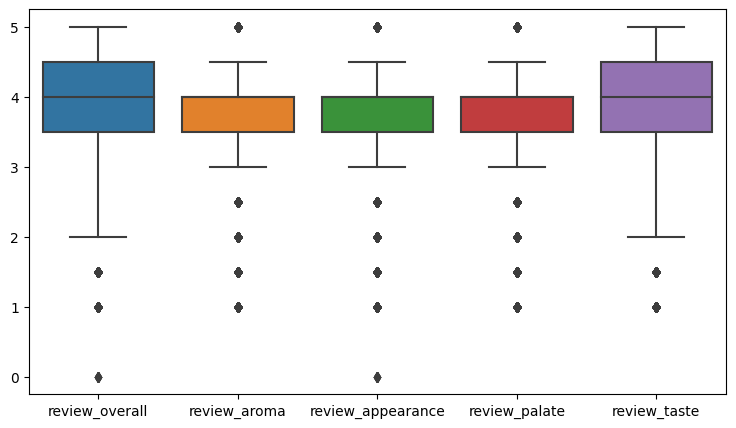

In [68]:
plt.figure(figsize=(9, 5))
sns.boxplot(data=beer_df[['review_overall', 'review_aroma', 'review_appearance', 'review_palate', 'review_taste']])
plt.show()

Return the 20 most commont beer styles.

In [69]:
beer_df['beer_style'].value_counts().head(20)

American IPA                        113144
American Double / Imperial IPA       85105
American Pale Ale (APA)              58072
Russian Imperial Stout               53424
American Double / Imperial Stout     50137
American Porter                      46647
American Amber / Red Ale             41731
Belgian Strong Dark Ale              37498
Fruit / Vegetable Beer               31983
American Strong Ale                  31350
Belgian Strong Pale Ale              31323
Saison / Farmhouse Ale               30621
Tripel                               29971
American Adjunct Lager               28964
Witbier                              28654
American Barleywine                  26267
Hefeweizen                           25922
American Brown Ale                   24131
American Pale Wheat Ale              22888
English Pale Ale                     22817
Name: beer_style, dtype: int64

Return the 20 most commont brewery names.

In [70]:
beer_df['brewery_name'].value_counts().head(30)

Boston Beer Company (Samuel Adams)      38806
Dogfish Head Brewery                    33790
Stone Brewing Co.                       33009
Sierra Nevada Brewing Co.               28632
Bell's Brewery, Inc.                    24973
Rogue Ales                              23446
Founders Brewing Company                19951
Victory Brewing Company                 19401
Lagunitas Brewing Company               16766
Avery Brewing Company                   16042
Southern Tier Brewing Company           15856
Anheuser-Busch                          15439
Great Divide Brewing Company            14902
Goose Island Beer Co.                   14208
Three Floyds Brewing Co. & Brewpub      14026
Unibroue                                13915
Brooklyn Brewery                        13719
New Belgium Brewing                     13349
Weyerbacher Brewing Co.                 12185
Flying Dog Brewery                      11690
Tröegs Brewing Company                  11613
Russian River Brewing Company     

In [71]:
beer_df['beer_name'].value_counts().head(100)

90 Minute IPA                          3289
Old Rasputin Russian Imperial Stout    3110
Sierra Nevada Celebration Ale          2999
India Pale Ale                         2960
Two Hearted Ale                        2727
                                       ... 
Yeti Imperial Stout                    1429
Oak Aged Yeti Imperial Stout           1422
Delirium Tremens                       1420
Anchor Liberty Ale                     1417
The Abyss                              1412
Name: beer_name, Length: 100, dtype: int64

Return the 20 most common beer_abv.

In [72]:
beer_df['beer_abv'].value_counts().head(20)

5.0     109116
8.0      67730
6.0      65375
7.0      59446
9.0      59171
5.5      59001
10.0     54772
6.5      48362
5.2      43254
7.5      39973
8.5      38465
5.4      33113
4.9      30894
9.5      29992
4.5      29343
5.3      29075
5.6      28907
5.8      28568
4.8      27092
5.1      25117
Name: beer_abv, dtype: int64

In [73]:
beer_df['review_profilename'].value_counts().head(100)

northyorksammy    5346
mikesgroove       4283
BuckeyeNation     4246
Thorpe429         3273
brentk56          3186
                  ... 
avalon07          1510
Deuane            1504
JoeyBeerBelly     1492
tgbljb            1492
BeerFMAndy        1483
Name: review_profilename, Length: 100, dtype: int64

In [74]:
beer_df['review_time'].dt.year.value_counts().head(20)

2011    322556
2010    268577
2009    235275
2008    201580
2007    135695
2006    122199
2005     83551
2004     64836
2003     52114
2002     20775
2012      9343
2001      1773
2000        98
1998        72
1999        33
1996         1
Name: review_time, dtype: int64

#### 1.4 - Downsampling - Option A - keep one year only

In [75]:
sub_beer_df = beer_df[beer_df['review_time'].dt.year == 2012].copy()
sub_beer_df.shape

(9343, 13)

In [76]:
users_reviews_count = sub_beer_df['review_profilename'].value_counts()
kept_profiles_only = users_reviews_count[users_reviews_count>1].index

In [77]:
sub_beer_df = sub_beer_df[sub_beer_df['review_profilename'].isin(kept_profiles_only)].copy()
sub_beer_df.nunique()

brewery_id            1103
brewery_name          1099
review_time           8600
review_overall           9
review_aroma             9
review_appearance        9
review_profilename    1366
beer_style             102
review_palate            9
review_taste             9
beer_name             3888
beer_abv               216
beer_id               3945
dtype: int64

# 2 - Graph Construction

#### 2.1 - Create the user-beer bipartite graph

In [78]:
G = nx.Graph()

# Add nodes and edges to the graph
for _, row in sub_beer_df.iterrows():
    G.add_node(row['review_profilename'], bipartite='user')
    G.add_node(row['beer_name'], bipartite='beer')
    G.add_edge(row['review_profilename'], row['beer_name'])

nx.bipartite.is_bipartite(G)

True

In [79]:
print(G)

Graph with 5254 nodes and 8641 edges


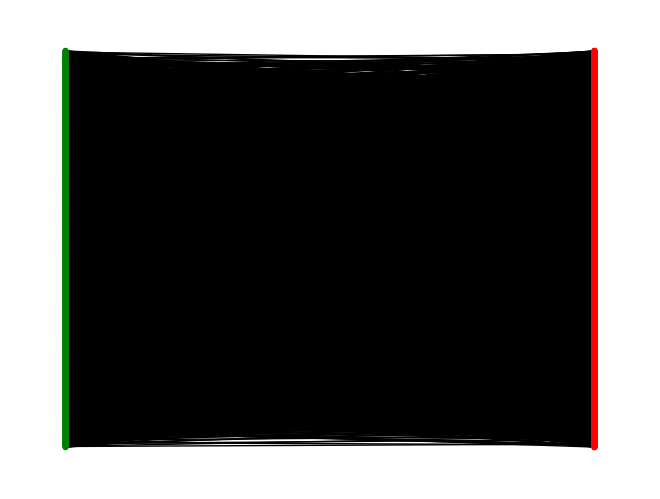

In [80]:
user_nodes = {n for n, d in G.nodes(data=True) if d['bipartite'] == 'user'}
beer_nodes = set(G) - user_nodes

node_colors = ['green' if d['bipartite'] == 'user' else 'red' for n, d in G.nodes(data=True)]

nx.draw(G, pos=nx.bipartite_layout(G, user_nodes), node_color = node_colors, node_size=10)

#### 2.2 - Projections

In [81]:
user_projection = nx.Graph()
user_projection = nx.bipartite.projected_graph(G, user_nodes)

Visualize the user projection

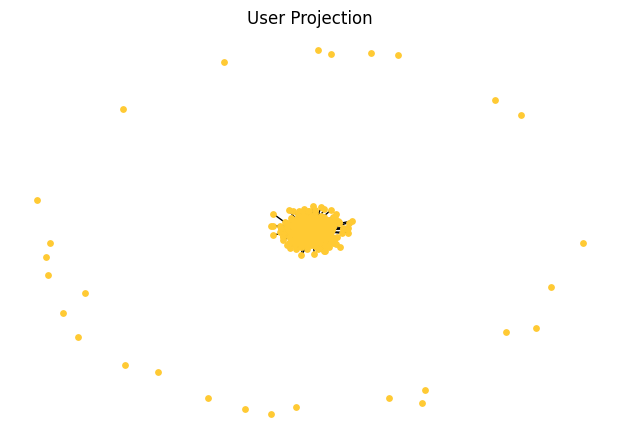

In [82]:
plt.figure(figsize=(6, 4))
pos_user = nx.spring_layout(user_projection)
nx.draw(user_projection, pos=pos_user, node_color='#FFCA33', edge_color='black', node_size=15)
plt.title('User Projection')
plt.show()

In [83]:
print(user_projection)

Graph with 1366 nodes and 19237 edges


# 3 - Basic Graph Properties

#### 3.1 - Density

Density for the user graph.

In [84]:
user_density = nx.density(user_projection)
user_density

0.020634026783367926

#### 3.2 - Degree Statistics

Degree statistics for the user graph.

In [85]:
user_degree = np.array([d for _, d in user_projection.degree()])

print(f"Avg User Degree: {np.mean(user_degree)}")
print(f"Min User Degree: {np.min(user_degree)}")
print(f"Max User Degree: {np.max(user_degree)}")
print(f"Median User Degree: {np.median(user_degree)}")
print(f"Std User Degree: {np.std(user_degree)}")

Avg User Degree: 28.16544655929722
Min User Degree: 0
Max User Degree: 186
Median User Degree: 19.0
Std User Degree: 26.874206843518703


#### 3.3 - Degree Distribution

In [86]:
def plot_degree_dist(G, bins, title):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees, bins=bins, color='#FFCA33', edgecolor='black', lw=0.15)
    plt.tight_layout()
    plt.title(title)
    plt.show()

Degree distribution of the user graph.

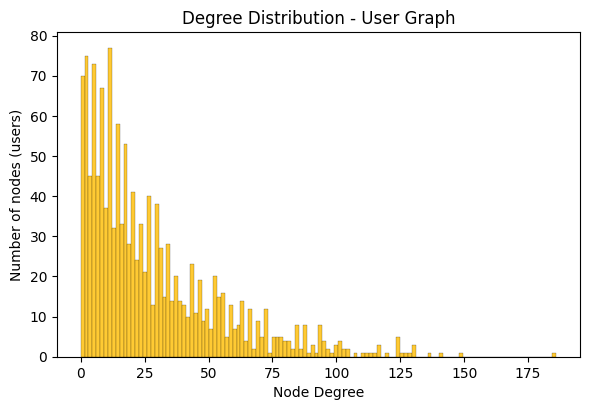

In [87]:
plt.figure(figsize=(6,4))
plt.ylabel('Number of nodes (users)')
plt.xlabel('Node Degree')
plot_degree_dist(user_projection, bins=len(np.unique(user_degree)), title='Degree Distribution - User Graph')

#### 3.4 - Comparison real network (users) vs. random network

From page 25 my notes: start by obtaining $N_{k}$, i.e., the number of nodes with degree $k$. This variable is called `user_degree_count`.

If `user_degree_count` is printed, we can see that there are 171 nodes (users) having degree=0, 145 nodes (users) having degree=1, and so on...

In [181]:
# create a list of degrees associated with each user
user_degree_sequence = list(dict(user_projection.degree()).values())

# initialize a dictionary
user_degree_count = defaultdict(int)

# for each distinct degree, count the number of nodes with that degree
for d in user_degree_sequence:
    user_degree_count[d]+=1

# sort by the keys(items) in ascending order
user_degree_count = dict(sorted(user_degree_count.items()))

The second step consists of computing: $p_k = \frac{N_{k}}{N}$, i.e. the degree distribution - in this case - of the users' nodes.

In [182]:
degree_distribution_users = []

for i in user_degree_count.values():        # i represents N_k
    degree_distribution_users.append(i/user_projection.order())     # N = user_projection.order()

Now that we have everything to plot the degree distribution of the real network, we need an equivalent random network and use it to make comparison.

In [183]:
# generate a RN(N=N, p=density)
random_network_user = nx.gnp_random_graph(n=user_projection.order(), p=user_density)
print(random_network_user)

Graph with 1366 nodes and 19409 edges


Repeat the same steps done for the random network.

In [184]:
# create a list of degrees associated with each user
random_network_user_degree_sequence = list(dict(random_network_user.degree()).values())

# initialize a dictionary
random_network_user_degree_count = defaultdict(int)

# for each distinct degree, count the number of nodes with that degree
for d in random_network_user_degree_sequence:
    random_network_user_degree_count[d]+=1

# sort by the keys(items) in ascending order
random_network_user_degree_count = dict(sorted(random_network_user_degree_count.items()))

In [185]:
degree_distribution_random_network_users = []

for i in random_network_user_degree_count.values():        # i represents N_k
    degree_distribution_random_network_users.append(i/random_network_user.order())     # N = user_projection.order()

Finally visualize the two distributions.

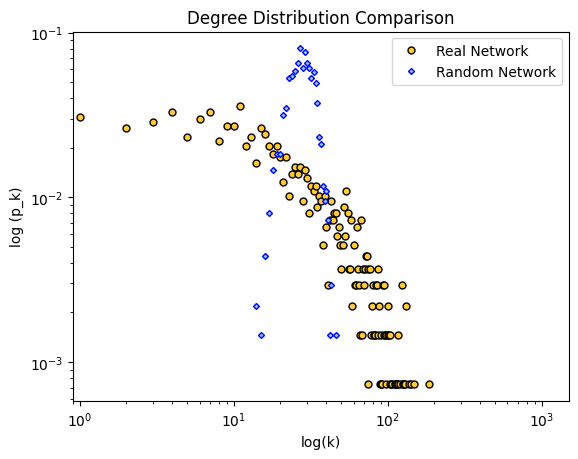

In [186]:
plt.loglog(user_degree_count.keys(), degree_distribution_users, 
           'o', label='Real Network', color='#FFCA33', markersize=5,
           mec='black', lw=0)
plt.loglog(random_network_user_degree_count.keys(), degree_distribution_random_network_users,
           'D', label='Random Network', color='skyblue', markersize=3,
           mec='blue', lw=0)
plt.ylabel('log (p_k)')
plt.xlabel('log(k)')
plt.legend()
plt.title('Degree Distribution Comparison')
plt.xlim(0.9,1500)
plt.show()

#### 3.5 - Comparison ECCDF real vs. random network (users)

Compute the ECCDF for the users distribution.

In [187]:
cp_k_user = np.cumsum(degree_distribution_users)
eccdf_users = [1-c for c in cp_k_user]

In [188]:
plot_degree_users = list(user_degree_count.keys())
rn_user_plot_degree = list(random_network_user_degree_count.keys())

Compute the ECCDF for the random users distribution.

In [189]:
cp_k_random_user = np.cumsum(degree_distribution_random_network_users)
eccdf_users_random = [1-c for c in cp_k_random_user]

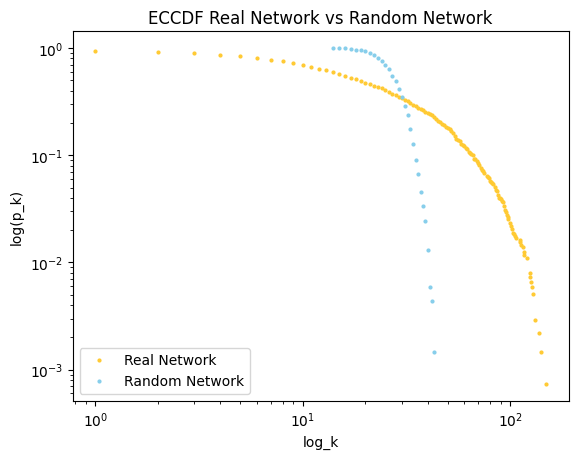

In [190]:
plt.loglog(plot_degree_users[:len(plot_degree_users)-1], eccdf_users[:len(eccdf_users)-1],
            'o', markersize=2, color = '#FFCA33', label='Real Network')
plt.loglog(rn_user_plot_degree[:len(rn_user_plot_degree)-1], eccdf_users_random[:len(eccdf_users_random)-1],
           'o', markersize=2, color='skyblue', label='Random Network')
plt.ylabel('log(p_k)')
plt.xlabel('log_k')
plt.legend()
plt.title('ECCDF Real Network vs Random Network')
plt.show()

# 4 - Centrality

- degree centrality
- closeness centrality
- betweenness centrality
- eigenvector centrality
- PageRank
- Katz

In [191]:
def centrality_revealer(centrality_measure, n=5):
    centrality_measure=list(centrality_measure.items())
    centrality_measure.sort(key=lambda x:x[1], reverse=True)
    centrality_measure = [(node,round(value, 2)) for node, value in centrality_measure]
    print(centrality_measure[:n])

#### 4.1 - Centrality measures on the `users` graph.

In [192]:
deg_cent_users = nx.degree_centrality(user_projection)
clo_cent_users = nx.closeness_centrality(user_projection)
bet_cent_users = nx.betweenness_centrality(user_projection)
eig_cent_users = nx.eigenvector_centrality(user_projection)

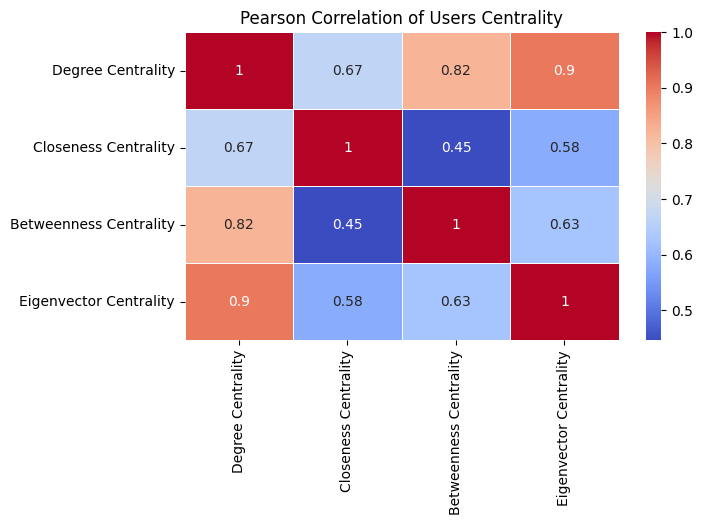

In [193]:
centrality_data_user = {
    'Degree Centrality': list(deg_cent_users.values()),
    'Closeness Centrality': list(clo_cent_users.values()),
    'Betweenness Centrality': list(bet_cent_users.values()),
    'Eigenvector Centrality': list(eig_cent_users.values())
}

# Convert the data to a DataFrame
centrality_user_df = pd.DataFrame(centrality_data_user)

# Compute the Pearson correlation matrix
cm_user = centrality_user_df.corr()

# Set up a seaborn heatmap for visualization
plt.figure(figsize=(7, 4))
sns.heatmap(cm_user, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Pearson Correlation of Users Centrality')
plt.show()

Who are the most central users according to the corresponding centrality measures?

In [194]:
print('Degree Centrality: ')
centrality_revealer(deg_cent_users)
print(' ')
print('Closeness Centrality:')
centrality_revealer(clo_cent_users)
print(' ')
print('Betweenness Centrality:')
centrality_revealer(bet_cent_users)
print(' ')
print('Eigenvector Centrality:')
centrality_revealer(eig_cent_users)

Degree Centrality: 
[('Knapp85', 0.14), ('gtermi', 0.11), ('kojevergas', 0.1), ('tsauce2', 0.1), ('jmarsh123', 0.1)]
 
Closeness Centrality:
[('Knapp85', 0.49), ('kojevergas', 0.48), ('mdaschaf', 0.48), ('gtermi', 0.48), ('phichifiji00', 0.47)]
 
Betweenness Centrality:
[('Knapp85', 0.04), ('kojevergas', 0.02), ('DrinkSlurm', 0.02), ('gtermi', 0.02), ('jmarsh123', 0.02)]
 
Eigenvector Centrality:
[('StoneBrewFanatic', 0.14), ('Tucquan', 0.13), ('marlinsfan4', 0.12), ('dogfishandi', 0.11), ('socon67', 0.11)]


PageRank

In [195]:
# 1. Compute PageRank centrality
pagerank_centrality = nx.pagerank(user_projection)

# 2. Sort nodes based on centrality values
sorted_nodes = sorted(pagerank_centrality.items(), key=lambda x: x[1], reverse=True)

# 3. Retrieve top 5 nodes with highest centrality values
top_5_nodes = sorted_nodes[:5]

# Print the top 5 nodes and their centrality values
for node, centrality in top_5_nodes:
    print(f"Node: {node}, PageRank Centrality: {centrality}")

Node: Knapp85, PageRank Centrality: 0.00476354827311242
Node: kojevergas, PageRank Centrality: 0.003411819433148208
Node: gtermi, PageRank Centrality: 0.003300113063391588
Node: DrinkSlurm, PageRank Centrality: 0.003007707900995
Node: jmarsh123, PageRank Centrality: 0.0030044003784210844


Katz centrality

In [196]:
# 1. Compute Katz centrality
katz_centrality = nx.katz_centrality(G, alpha=0.09, max_iter=1000)

# 2. Sort nodes based on centrality values
sorted_nodes = sorted(katz_centrality.items(), key=lambda x: x[1], reverse=True)

# 3. Retrieve top 5 nodes with highest centrality values
top_5_nodes = sorted_nodes[:5]

# Print the top 5 nodes and their centrality values
for node, centrality in top_5_nodes:
    print(f"Node: {node}, Katz Centrality: {centrality}")

Node: Rifugium, Katz Centrality: 0.2875340588542324
Node: Knapp85, Katz Centrality: 0.175278489418733
Node: Huhzubendah, Katz Centrality: 0.13278963565488272
Node: MasterSki, Katz Centrality: 0.1306036803256974
Node: Thorpe429, Katz Centrality: 0.12837345047000023


# 5 - Connectivity

_"A graph is `connected` if there exists a path between any two nodes in it."_

_"A `connected component` is a subgraph of a network such that there exists at least one path from each member of that subgraph to each other member"_

_Can a network have two or more large components that fill a sizeable fraction of the entire graph? The answer is NO --> There is typically one strongly connected component and a selection of small ones._

#### 5.1 - User Network

In [197]:
print(nx.is_connected(user_projection))
print(nx.number_connected_components(user_projection))

False
29


Retrieve the connected components and their corresponding size.

In [210]:
# Retrieve the members of each component
components_user = [cc for cc in nx.connected_components(user_projection)]

# Compute the number of users in each connected component
len_cc_user = [len(cc) for cc in nx.connected_components(user_projection)]
len_cc_user[:15]

[1338, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Retrieve the dimensions of the largest cc, and compute ASPL and diameter.

In [199]:
# Compute the largest connected component
lcc_user = user_projection.subgraph(components_user[0])
print(lcc_user)

# Compute average shortest path length for the lcc_user
print(nx.average_shortest_path_length(lcc_user))

# obtain the diameter
print(nx.diameter(lcc_user))

Graph with 1338 nodes and 19237 edges
2.650206327218982
6


_This means that, on average, it takes approximately 2.65 connections to travel from one user to another within the largest connected component. A lower ASPL indicates a more tightly connected network, where users are, on average, closer to each other in terms of connectivity._

_The relatively low average shortest path length (2.65) suggests that, on average, users within the largest connected component are closely connected. The network allows for efficient communication or traversal between users._

_The diameter of a connected component is the length of the longest shortest path between any pair of nodes in that component. Diameter=6 means that the longest chain of connections between any two users within the largest connected component consists of 6 steps.The diameter provides a sense of the "maximum distance" between any two users in the largest connected component._

In [77]:
len(lcc_user)/sum(len_cc_user)

0.9795021961932651

_The largest cc for users covers more than 97% of the whole user_projection!_

Reproduce the plot in slide 8/14 'connectivity'.

Text(0.5, 1.0, 'Components Size distribution')

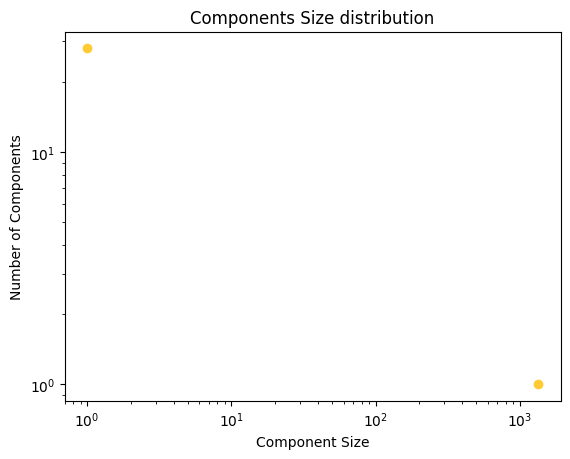

In [208]:
components_user_dict = defaultdict(int)

for cc in len_cc_user:
    components_user_dict[cc] +=1

plt.loglog(components_user_dict.keys(), components_user_dict.values(), 'o', color='#FFCA33')
plt.ylabel('Number of Components')
plt.xlabel('Component Size')
plt.title('Components Size distribution')

# 6 - Transitivity

Topics: 
- global and local clustering coefficient
- triangles
- comment real vs. random network

#### 6.1 - Users

In [211]:
# Number of triangles
user_triangles = nx.triangles(user_projection)
user_triangles = sorted(user_triangles.items(), key=lambda x:x[1], reverse=True)
user_triangles[:5]

[('StoneBrewFanatic', 2506),
 ('Tucquan', 2161),
 ('marlinsfan4', 2083),
 ('dogfishandi', 1803),
 ('tsauce2', 1751)]

In [213]:
# Global Clustering Coefficient
print(f"Global Clustering Coefficient: {nx.transitivity(user_projection)}")

# Local Clustering Coefficient
print(f"Local Clustering Coefficient: {nx.average_clustering(user_projection)}")

Global Clustering Coefficient: 0.31710176599137674
Local Clustering Coefficient: 0.44769878514688494


Compare with a Random network

In [269]:
print(f"Global Clustering Coefficient - Random: {nx.transitivity(random_network_user)}")

print(f"Local Clustering Coefficient - Randomr: {nx.average_clustering(random_network_user)}")

Global Clustering Coefficient - Random: 0.02102023727965724
Local Clustering Coefficient - Randomr: 0.02087732929939511


_"Real networks have higher clustering coefficient than random networks!"_

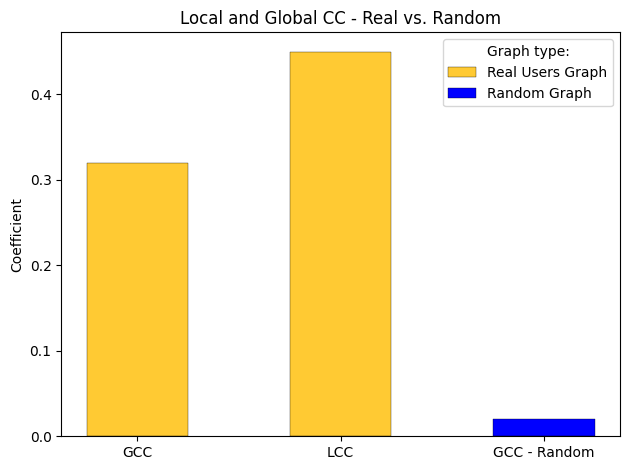

In [254]:
fig, ax = plt.subplots()

cluster = ['GCC', 'LCC', 'GCC - Random']
values = [0.32, 0.45, 0.02]
bar_labels = ['Real Users Graph', '_Users Graph', 'Random Graph']
bar_colors = ['#FFCA33', '#FFCA33', 'blue']

ax.bar(cluster, values, label=bar_labels, color=bar_colors, width=0.5,
       align='center',
       edgecolor='black', lw=0.25)

ax.set_ylabel('Coefficient')
ax.set_title('Local and Global CC - Real vs. Random')
ax.legend(title='Graph type:')

plt.tight_layout()
plt.show()

C:\Users\giord\AppData\Local\Temp\ipykernel_36544\729140222.py:28: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


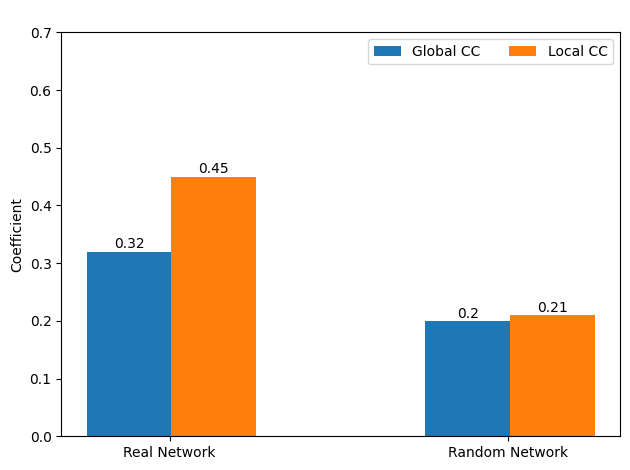

In [295]:
# graphs = ('Real Graph', 'Random Graph')
clusters = ('Real Network', 'Random Network')

clustering_coefficients = {
    'Global CC' : (0.32, 0.2),
    'Local CC': (0.45, 0.21)
}

x = np.arange(len(clusters))
width=0.25
multiplier=0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in clustering_coefficients.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, align='center', label=attribute)
    ax.bar_label(rects, padding=0.1)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Coefficient')
ax.set_title(' ')
ax.set_xticks(x + .12, clusters)
ax.legend(loc='upper right', ncols=2)
ax.set_ylim(0, 0.7)

plt.tight_layout()
plt.show()

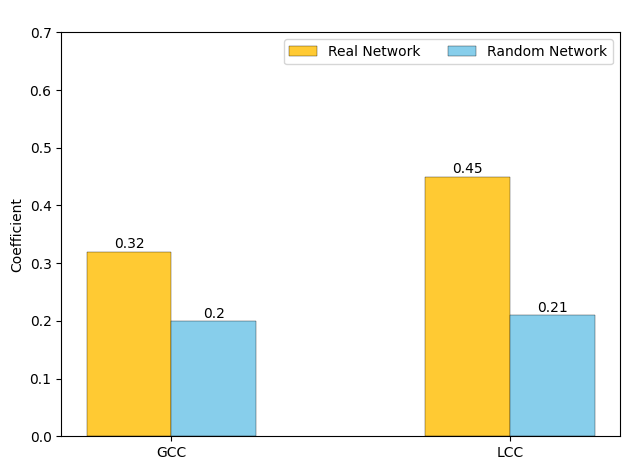

In [321]:
# graphs = ('Real Graph', 'Random Graph')
clusters = ('GCC', 'LCC')

clustering_coefficients = {
    'Real Network' : (0.32, 0.45),
    'Random Network': (0.2, 0.21)
}

x = np.arange(len(clusters))
width=0.25
multiplier=0

fig, ax = plt.subplots()

for attribute, measurement in clustering_coefficients.items():

    if attribute == 'Real Network':
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, align='center', label=attribute, color='#ffca33',
                       edgecolor='black', lw=0.25)
        ax.bar_label(rects, padding=0.1)
        multiplier += 1
    
    else:
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, align='center', label=attribute, color='skyblue',
        edgecolor='black', lw=0.25)
        ax.bar_label(rects, padding=0.1)
        multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Coefficient')
ax.set_title(' ')
ax.set_xticks(x + .125, clusters)
ax.legend(loc='upper right', ncols=2)
ax.set_ylim(0, 0.7)

plt.tight_layout()
plt.show()

In [302]:
clustering_coefficients.keys()

dict_keys(['Real Network', 'Random Network'])

# 7 - Strong and Weak Ties

**Definition 7.1**:_"A `bridge` in a graph is an edge whose removal causes the number of connected components of the graph to increase. Equivalently, a bridge is an edge that does not belong to any cycle."_

**Definition 7.2**: _"A `local bridge` is an edge whose endpoints have no common neighbors. That is, the edge is not part of a triangle in the graph."_

_"Analyzing bridges and local bridges can provide insights into the critical edges that, if removed, could impact the overall connectivity or local structure of your network. It's a valuable analysis for understanding the resilience and vulnerability of the network."_

#### 7.1 - Users

In [88]:
nx.has_bridges(user_projection)

True

In [89]:
bridges_user = len(list(nx.bridges(user_projection)))
print(bridges_user)
print(bridges_user/nx.number_of_edges(user_projection))

42
0.0021832926131933254


In [90]:
local_bridges_user = len(list(nx.local_bridges(user_projection)))
print(local_bridges_user)
print(local_bridges_user/nx.number_of_edges(user_projection))

293
0.015231065134896294


# 8 - Network Similarity (Assortativity)

#### 8.1 - Average neighbor degree, average neighbor connectivity
- https://stackoverflow.com/questions/56624273/understanding-average-degree-connectivity-in-networkx

In [258]:
# Average degree connectivity. _Compute the average degree connectivity of graph_
print(nx.average_neighbor_degree(user_projection))
print(f"Average degree connectivity: {nx.average_degree_connectivity(user_projection)}")

{'shrek806': 49.0, 'scruffwhor': 42.294117647058826, 'MTNboy': 19.0, 'Vancoubeer': 68.97435897435898, 'CopeTech': 57.75, 'argon': 14.0, 'RonBeerBox': 36.48275862068966, 'rootbeerman': 57.65714285714286, 'buyBinboaVodka': 47.75, 'Immortale25': 49.301587301587304, 'barnzy78': 56.916666666666664, 'jneiswender': 46.44444444444444, 'TenHornsProud': 66.71134020618557, 'prototypic': 50.666666666666664, 'nataku00': 55.0, 'Brewermeister': 57.138888888888886, 'portia99': 66.82978723404256, 'kbuzz': 37.285714285714285, 'comfortablynumb1': 40.833333333333336, 'July2Nov': 0.0, 'Arbitrator': 49.06666666666667, 'drgarage': 51.333333333333336, 'Neorebel': 47.22222222222222, 'BelgiumBill': 49.09090909090909, 'czfreeman': 45.285714285714285, 'iadler': 57.29032258064516, 'DrDemento456': 48.220588235294116, 'mulder1010': 30.142857142857142, 'DrJay': 50.37931034482759, 'BUNZILLA': 48.9, 'gkunkle': 38.75, 'homebrewhawk': 51.8125, 'TurdFurgison': 33.44444444444444, 'welldigger888': 47.27272727272727, 'silent

#### 8.2 - Neighborhood Similarity, Structural Equivalence (Users)

_"We look at the neighborhood shared by two nodes: the size of the neighborhood defines how similar two nodes are."_

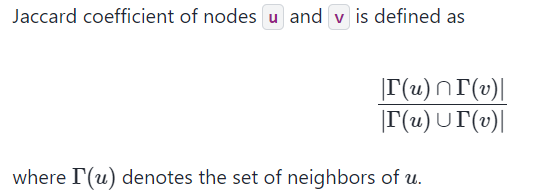

In [95]:
high_degree = dict(user_projection.degree())
high_degree = sorted(high_degree.items(), key=lambda x: x[1], reverse=True)[:5]
high_degree = dict(high_degree)
high_degree

{'Knapp85': 186,
 'gtermi': 149,
 'kojevergas': 141,
 'tsauce2': 137,
 'jmarsh123': 131}

In [96]:
# Compute Jaccard similarity for pairs of high-degree nodes
jaccard_similarities = jaccard_coefficient(user_projection, itertools.combinations(high_degree, 2))

# Print Jaccard similarities
for u, v, jaccard in jaccard_similarities:
    print(f"Jaccard similarity between {u} and {v}: {round(jaccard, 2)}")

Jaccard similarity between Knapp85 and gtermi: 0.1
Jaccard similarity between Knapp85 and kojevergas: 0.09
Jaccard similarity between Knapp85 and tsauce2: 0.06
Jaccard similarity between Knapp85 and jmarsh123: 0.08
Jaccard similarity between gtermi and kojevergas: 0.09
Jaccard similarity between gtermi and tsauce2: 0.14
Jaccard similarity between gtermi and jmarsh123: 0.07
Jaccard similarity between kojevergas and tsauce2: 0.07
Jaccard similarity between kojevergas and jmarsh123: 0.05
Jaccard similarity between tsauce2 and jmarsh123: 0.08


#### 8.3 - Attributes Similarity, Assortativity

https://arxiv.org/pdf/cond-mat/0209450.pdf 

The function below computes equation 21 in the mentioned paper. The computed coefficient is called $r$, where $r \in [-1,1]$:
- $r=1$ indicates perfect assortativity
- $r=-1$ indicates perfect dis-assortativity


_"Positive values of r indicate a correlation between nodes of similar degree, while negative values indicate relationships between nodes of different degree."_

_"The assortativity coefficient **$r$** measures the correlation between the degrees of connected nodes in a network. When the coefficient is positive, it indicates a tendency for nodes of similar degree to be connected, while negative values suggest that nodes of different degrees are more likely to be connected."_

_"To calculate the assortativity coefficient, NetworkX considers all pairs of connected nodes in the network and compares their degrees. It computes the expected joint degree distribution $q_{i}q_{j}$ based on the degrees of the nodes and compares it to the observed joint degree distribution $e_{ij}$. The coefficient $r$ is then calculated based on these comparisons, providing a measure of how the actual connections in the network deviate from what would be expected if nodes were connected randomly."_

In [97]:
print(nx.degree_assortativity_coefficient(user_projection))
# print(nx.degree_assortativity_coefficient(beer_projection))

0.060453799433484286


#### 8.4 - Modularity for the user graph

Modularity is computed as:
$Q = \frac{1}{2m} \sum_{ij} \left( A_{ij} - \gamma\frac{k_ik_j}{2m}\right)
    \delta(c_i,c_j)$

where $\delta(c_i,c_j)$ = 1 if $i$ and $j$ are in the same community, 0 otherwise.

_"Positive modularity values indicate that the network has a structure where the connections within communities are denser than expected by random chance, while connections between communities are sparser."_

Modularity for the usual user graph:

In [98]:
Q = modularity(user_projection, nx.community.louvain_communities(user_projection))
print("Modularity:", round(Q, 2))

Modularity: 0.38


#### 8.5 - Homophily: Difference in modularity between 2012 and 2011

We may be interested in computing the "current" modularity with the analog measure one period before. Since I've been considering year 2012, let's test it on 2011.

In [99]:
sub_beer_df = beer_df[beer_df['review_time'].dt.year == 2011].copy()
sub_beer_df.shape

(322556, 13)

In [100]:
users_reviews_count = sub_beer_df['review_profilename'].value_counts()
kept_profiles_only = users_reviews_count[users_reviews_count>1].index

In [101]:
sub_beer_df = sub_beer_df[sub_beer_df['review_profilename'].isin(kept_profiles_only)].copy()
sub_beer_df.nunique()

brewery_id              3501
brewery_name            3468
review_time           316424
review_overall             9
review_aroma               9
review_appearance          9
review_profilename      8112
beer_style               104
review_palate              9
review_taste               9
beer_name              23107
beer_abv                 424
beer_id                24689
dtype: int64

In [102]:
G_2011 = nx.Graph()

# Add nodes and edges to the graph
for _, row in sub_beer_df.iterrows():
    G_2011.add_node(row['review_profilename'], bipartite='user')
    G_2011.add_node(row['beer_name'], bipartite='beer')
    G_2011.add_edge(row['review_profilename'], row['beer_name'])

In [103]:
user_nodes_2011 = {n for n, d in G_2011.nodes(data=True) if d['bipartite'] == 'user'}
beer_nodes_2011 = set(G_2011) - user_nodes_2011

user_projection_2011 = nx.Graph()
user_projection_2011 = nx.bipartite.projected_graph(G_2011, user_nodes_2011)

Now that the graph of the previous year has been retrieved, apply the same Modularity measure

In [104]:
Q_2011 = modularity(user_projection_2011, nx.community.louvain_communities(user_projection_2011))
print("Modularity:", round(Q_2011, 2))

Modularity: 0.1


See the difference:

In [105]:
print(f"Modularity change: {round(Q - Q_2011, 2)}")

Modularity change: 0.28


# 9 - Community Detection

#### 9.1 - Louvain Algorithm 

_partition = dictionary where the keys are the nodes in your network and the values are the community assignments for each node. Each node is assigned to a community._

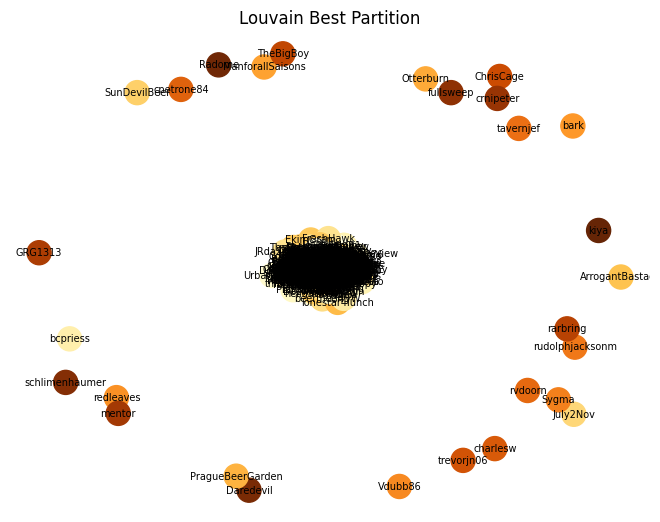

In [264]:
partition = louvain.best_partition(user_projection)

pos = nx.spring_layout(user_projection)

nx.draw(user_projection, pos, node_color=list(partition.values()), cmap='YlOrBr', with_labels=True, font_size=7)
plt.title('Louvain Best Partition')
plt.show()

In [266]:
# Analyze community structure
communities = {}
for node, community_id in partition.items():
    if community_id not in communities:
        communities[community_id] = [node]
    else:
        communities[community_id].append(node)

sorted_communities = sorted(communities.items(), key=lambda x:len(x[1]), reverse=True)

print("Number of communities detected:", len(sorted_communities))
for community_id, nodes in sorted_communities[:20]:
    print(f"Community {community_id}: {len(nodes)} nodes")

Number of communities detected: 41
Community 4: 184 nodes
Community 11: 151 nodes
Community 2: 143 nodes
Community 14: 132 nodes
Community 1: 129 nodes
Community 0: 110 nodes
Community 6: 100 nodes
Community 16: 84 nodes
Community 3: 75 nodes
Community 10: 75 nodes
Community 8: 64 nodes
Community 9: 57 nodes
Community 5: 34 nodes
Community 12: 1 nodes
Community 15: 1 nodes
Community 18: 1 nodes
Community 19: 1 nodes
Community 20: 1 nodes
Community 21: 1 nodes
Community 22: 1 nodes


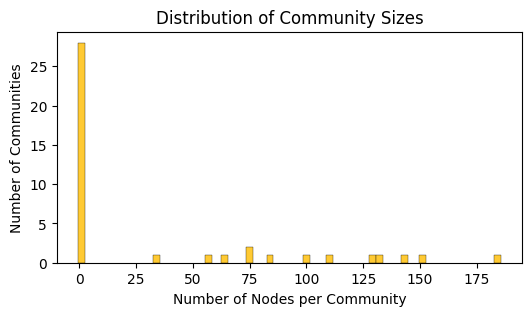

In [268]:
# Count the number of nodes in each community
nodes_per_community = [len(nodes) for _, nodes in communities.items()]

# Count the number of communities with a specific number of nodes
community_counts = {}
for value in nodes_per_community:
    if value not in community_counts:
        community_counts[value] = 1
    else:
        community_counts[value] += 1

# Create lists for x and y axes
x_values = list(community_counts.keys())
y_values = list(community_counts.values())

# Plot the data
plt.figure(figsize=(6, 3))
plt.bar(x_values, y_values, width=3, color='#ffca33', edgecolor='black', lw=0.25)
plt.xlabel('Number of Nodes per Community')
plt.ylabel('Number of Communities')
plt.title('Distribution of Community Sizes')
plt.show()

#### 9.2 - What is the most common beer style in the biggest community? And the most appreciated brewery among the users in that community?

In [228]:
community1= sorted_communities[0][1]
community_1 = sub_beer_df[sub_beer_df['review_profilename'].isin(community1)].copy()

In [229]:
round((community_1['beer_style'].value_counts(normalize=True)[:5]), 2)

American IPA                        0.08
American Double / Imperial IPA      0.07
American Double / Imperial Stout    0.05
Russian Imperial Stout              0.04
American Pale Ale (APA)             0.04
Name: beer_style, dtype: float64

In [230]:
(community_1['brewery_name'].value_counts(normalize=True)[:5])

Dogfish Head Brewery                  0.021258
Stone Brewing Co.                     0.021103
Boston Beer Company (Samuel Adams)    0.021026
Sierra Nevada Brewing Co.             0.018155
Founders Brewing Company              0.015789
Name: brewery_name, dtype: float64

#### 9.3 - What is the most common beer style in the second biggest community?

In [231]:
community2= sorted_communities[1][1]
community_2 = sub_beer_df[sub_beer_df['review_profilename'].isin(community2)].copy()

In [232]:
round((community_2['beer_style'].value_counts(normalize=True)[:5]), 2)

American IPA                        0.07
American Double / Imperial IPA      0.06
American Double / Imperial Stout    0.05
Russian Imperial Stout              0.04
American Pale Ale (APA)             0.03
Name: beer_style, dtype: float64

In [233]:
(community_2['brewery_name'].value_counts(normalize=True)[:5])

Boston Beer Company (Samuel Adams)    0.026931
Sierra Nevada Brewing Co.             0.019151
Stone Brewing Co.                     0.018934
Dogfish Head Brewery                  0.018716
Bell's Brewery, Inc.                  0.016540
Name: brewery_name, dtype: float64

#### 9.4 - What is the most common beer style in a smaller community?

In [234]:
community13= sorted_communities[13][1]
community_13 = sub_beer_df[sub_beer_df['review_profilename'].isin(community13)].copy()

In [235]:
round((community_13['beer_style'].value_counts(normalize=True)[:5]), 2)

American IPA                        0.09
American Double / Imperial IPA      0.07
American Pale Ale (APA)             0.06
American Double / Imperial Stout    0.04
American Porter                     0.04
Name: beer_style, dtype: float64

In [237]:
community_13['brewery_name'].value_counts(normalize=True)[:5]

Sierra Nevada Brewing Co.             0.022126
Boston Beer Company (Samuel Adams)    0.019856
Mikkeller ApS                         0.018911
Stone Brewing Co.                     0.015885
Victory Brewing Company               0.015696
Name: brewery_name, dtype: float64

# X - **Separator**

### **Option B - keep a certain number only**

Start from keeping 1% of the observations only. It's a huge downsampling, may re-evaluate this.

In [ ]:
sub_beer_df = beer_df.sample(n=1500, replace=False, random_state=40)
sub_beer_df.nunique()

brewery_id             516
brewery_name           516
review_time           1500
review_overall           9
review_aroma             9
review_appearance        9
review_profilename    1160
beer_style              99
review_palate            9
review_taste             9
beer_name             1187
beer_abv               144
beer_id               1198
dtype: int64

In [ ]:
sub_beer_df.shape

(1500, 13)

### **Option C - Stratified Sampling**

In [ ]:
# Calculate the number of reviews per user and per beer
user_review_counts = beer_df['review_profilename'].value_counts()
beer_review_counts = beer_df['beer_name'].value_counts()

# Define a threshold for the minimum number of reviews (adjust as needed)
user_threshold = 1200
beer_threshold = 1200

# Identify users and beers that meet the threshold
selected_users = user_review_counts[user_review_counts >= user_threshold].index
selected_beers = beer_review_counts[beer_review_counts >= beer_threshold].index

# Subset the data based on selected users and beers
sub_beer_df = beer_df[(beer_df['review_profilename'].isin(selected_users)) & (beer_df['beer_name'].isin(selected_beers))]

# Check the size of the filtered dataframe
print(sub_beer_df.shape)

(20264, 13)


In [ ]:
sub_beer_df.nunique()

brewery_id              341
brewery_name            337
review_time           20262
review_overall            9
review_aroma              9
review_appearance         9
review_profilename      156
beer_style               58
review_palate             9
review_taste              9
beer_name               143
beer_abv                 84
beer_id                 505
dtype: int64